In [95]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from joblib import Parallel, delayed
from sklearn.svm import SVR
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

plt.style.use('seaborn-bright')

import os
import warnings
warnings.filterwarnings('ignore')

In [96]:
path = '../input/store-sales-time-series-forecasting/'

In [97]:
df_train        = pd.read_csv(path + 'train.csv', usecols=[1,2,3,4,5])
df_oil          = pd.read_csv(path + 'oil.csv')
df_stores       = pd.read_csv(path + 'stores.csv')
df_holiday      = pd.read_csv(path + 'holidays_events.csv')
df_transactions = pd.read_csv(path + 'transactions.csv')

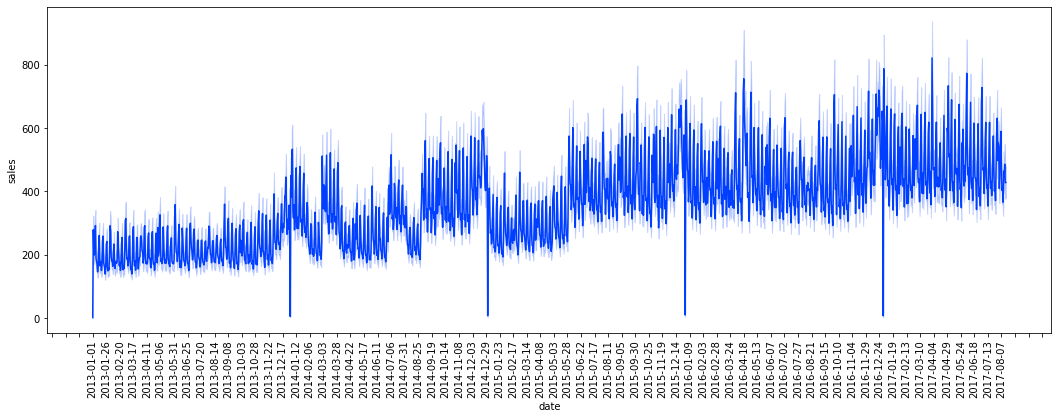

In [98]:
plt.figure(figsize=(18,6))
sns.lineplot(data = df_train,x='date',y='sales')
plt.xticks(rotation=90)

ax = plt.gca()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=25.0))
plt.show()

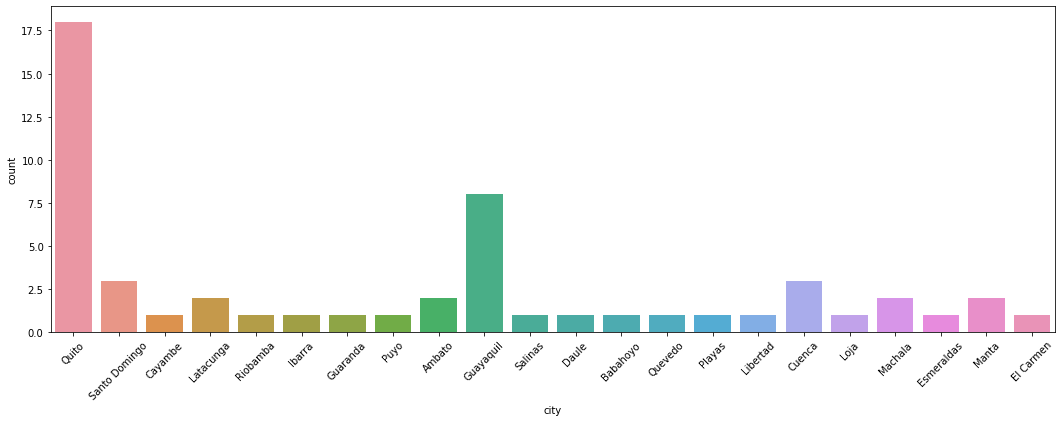

In [99]:
plt.figure(figsize=(18,6))
sns.countplot(data = df_stores,x='city')
plt.xticks(rotation=45)
plt.show()

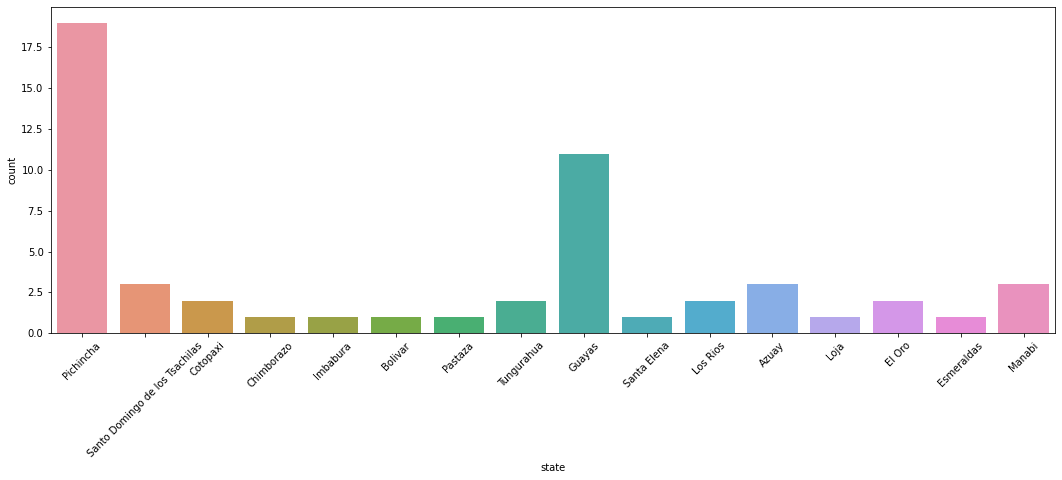

In [100]:
plt.figure(figsize=(18,6))
sns.countplot(data = df_stores,x='state')
plt.xticks(rotation=45)
plt.show()

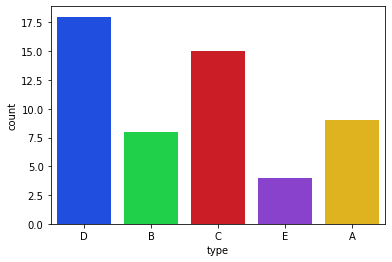

In [101]:
sns.countplot(data = df_stores,x='type')
plt.show()

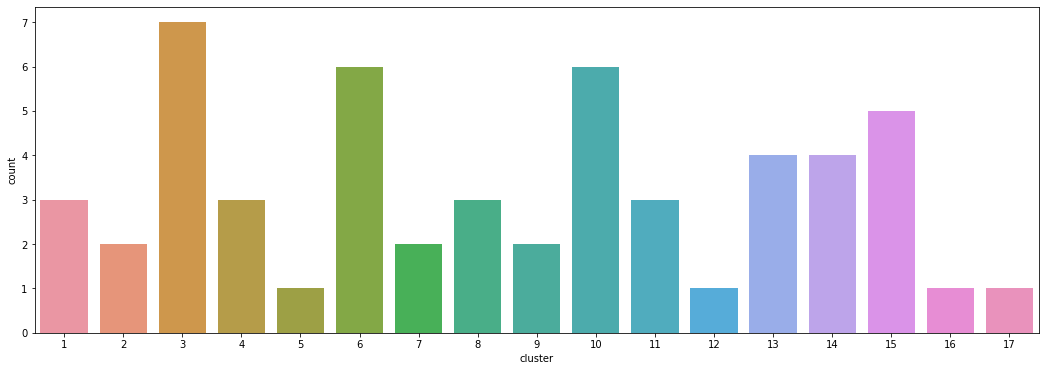

In [102]:
plt.figure(figsize=(18,6))
sns.countplot(data = df_stores,x='cluster')
plt.show()

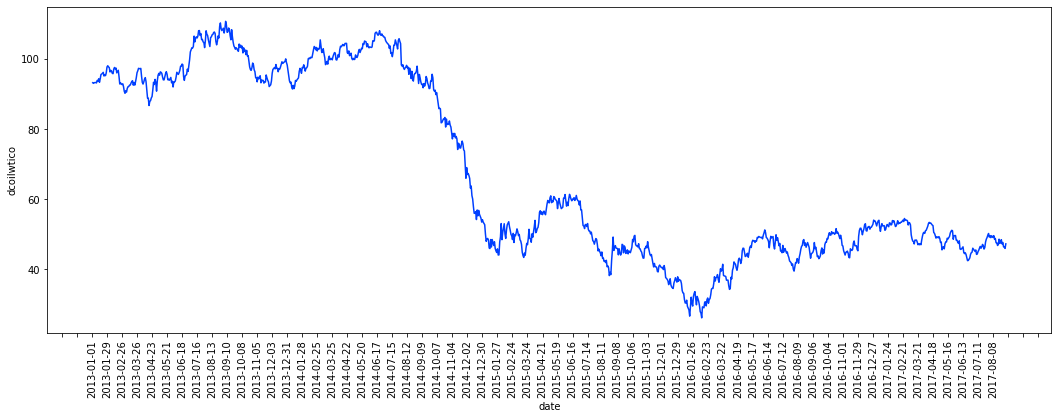

In [103]:
plt.figure(figsize=(18,6))
sns.lineplot(data = df_oil,x='date',y='dcoilwtico')
plt.xticks(rotation=90)

ax = plt.gca()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=20.0))
plt.show()

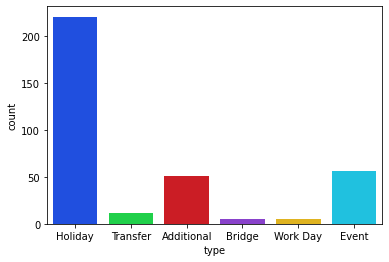

In [104]:
sns.countplot(data = df_holiday,x='type')
plt.show()

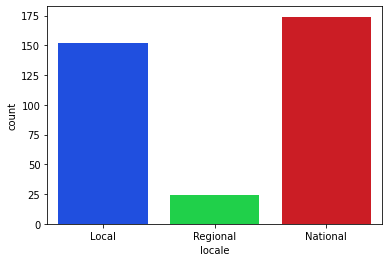

In [105]:
sns.countplot(data = df_holiday,x='locale')
plt.show()

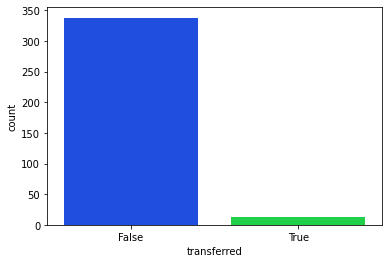

In [106]:
sns.countplot(data = df_holiday,x='transferred')
plt.show()

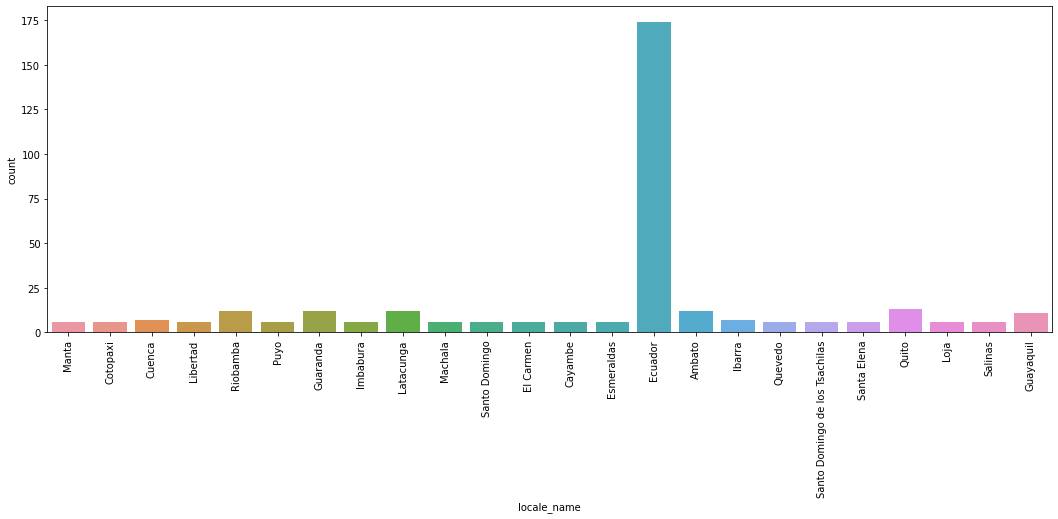

In [107]:
plt.figure(figsize=(18,6))
sns.countplot(data = df_holiday,x='locale_name')
plt.xticks(rotation=90)
plt.show()

In [108]:
train = pd.read_csv(path + 'train.csv',
                    parse_dates = ['date'], infer_datetime_format = True,
                    dtype = {'store_nbr' : 'category',
                             'family' : 'category'},
                   usecols = ['date', 'store_nbr', 'family', 'sales'])

train['date'] = train.date.dt.to_period('D')
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()

In [109]:
test = pd.read_csv(path + 'test.csv',
                   parse_dates = ['date'], infer_datetime_format = True)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['date', 'store_nbr', 'family']).sort_values('id')

In [110]:
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')
oil = pd.read_csv(path + 'oil.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')
oil['ma_oil'] = oil['dcoilwtico'].rolling(7).mean()
calendar = calendar.join(oil.ma_oil)
calendar['ma_oil'].fillna(method = 'ffill', inplace = True)
calendar.dropna(inplace = True)
n_lags = 3
for l in range(1, n_lags + 1) :
    calendar[f'oil_lags_{l}'] = calendar.ma_oil.shift(l)
calendar.dropna(inplace = True)

In [111]:
hol = pd.read_csv(path + 'holidays_events.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')
hol = hol[hol.locale == 'National'] 
hol = hol.groupby(hol.index).first() 

In [112]:
calendar = calendar.join(hol) 
calendar['dofw'] = calendar.index.dayofweek 
calendar['wd'] = 1
calendar.loc[calendar.dofw > 4, 'wd'] = 0 
calendar.loc[calendar.type == 'Work Day', 'wd'] = 1 
calendar.loc[calendar.type == 'Transfer', 'wd'] = 0 
calendar.loc[calendar.type == 'Bridge', 'wd'] = 0 
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = 0 
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True), 'wd'] = 1 
calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True) 
calendar = pd.get_dummies(calendar, columns = ['type']) 
calendar.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True) 

In [113]:
sdate = '2017-04-01' 
edate = '2017-08-15'

In [114]:
school_season = [] 
for i, r in calendar.iterrows() :
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else :
        school_season.append(0)
calendar['school_season'] = school_season

In [115]:
y_train = train.unstack(['store_nbr', 'family']).loc[sdate:edate]
fourier = CalendarFourier(freq = 'W', order = 3)
dp = DeterministicProcess(index = y_train.index,
                          order = 1,
                          seasonal = False,
                          constant = False,
                          additional_terms = [fourier],
                          drop = True)
x_train = dp.in_sample()
x_train = x_train.join(calendar)

In [116]:
x_test = dp.out_of_sample(steps = 16)
x_test = x_test.join(calendar)

In [117]:
x = x_train.copy()

In [118]:
x.drop(['school_season'], axis = 1, inplace = True)

In [119]:
model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True)
model.fit(x, y_train)
y_pred = pd.DataFrame(model.predict(x), index=x.index, columns=y_train.columns)
y_pred = y_pred.stack(['store_nbr', 'family']).clip(0.)
y_target = y_train.stack(['store_nbr', 'family']).clip(0.)

y_target['pred'] = y_pred.values

print(y_target.groupby('family').apply(lambda r : np.sqrt(np.sqrt(mean_squared_log_error(r['sales'], r['pred'])))))
print('RMSLE : ', np.sqrt(np.sqrt(mean_squared_log_error(y_target['sales'], y_target['pred']))))

family
AUTOMOTIVE                    0.712800
BABY CARE                     0.507791
BEAUTY                        0.717790
BEVERAGES                     0.667739
BOOKS                         0.404280
BREAD/BAKERY                  0.594754
CELEBRATION                   0.737009
CLEANING                      0.674807
DAIRY                         0.607126
DELI                          0.573868
EGGS                          0.619342
FROZEN FOODS                  0.622335
GROCERY I                     0.676902
GROCERY II                    0.766155
HARDWARE                      0.722893
HOME AND KITCHEN I            0.713226
HOME AND KITCHEN II           0.683912
HOME APPLIANCES               0.626700
HOME CARE                     0.589842
LADIESWEAR                    0.712787
LAWN AND GARDEN               0.681108
LINGERIE                      0.793929
LIQUOR,WINE,BEER              0.885704
MAGAZINES                     0.708436
MEATS                         0.591917
PERSONAL CARE     

In [120]:
model = LinearRegression(fit_intercept = True, n_jobs = -1, normalize = True)
model.fit(x_train, y_train)
y_pred = pd.DataFrame(model.predict(x_train), index=x_train.index, columns=y_train.columns)
y_pred = y_pred.stack(['store_nbr', 'family']).clip(0.)
y_target = y_train.stack(['store_nbr', 'family']).clip(0.)

y_target['pred'] = y_pred.values

print('RMSLE : ', np.sqrt(np.sqrt(mean_squared_log_error(y_target['sales'], y_target['pred']))))

RMSLE :  0.6942716503901292


In [121]:
model = Ridge(fit_intercept=True, solver='auto', alpha=0.75, normalize=True, random_state=5)
model.fit(x_train, y_train)
y_pred = pd.DataFrame(model.predict(x_train), index=x_train.index, columns=y_train.columns)
y_pred = y_pred.stack(['store_nbr', 'family']).clip(0.)
y_target = y_train.stack(['store_nbr', 'family']).clip(0.)

y_target['pred'] = y_pred.values

print('RMSLE : ', np.sqrt(np.sqrt(mean_squared_log_error(y_target['sales'], y_target['pred']))))

RMSLE :  0.7029830588882293


In [122]:
model = MultiOutputRegressor(SVR(C = 0.2, kernel = 'rbf'), n_jobs = -1)
model.fit(x_train, y_train)
y_pred = pd.DataFrame(model.predict(x_train), index=x_train.index, columns=y_train.columns)
y_pred = y_pred.stack(['store_nbr', 'family']).clip(0.)
y_target = y_train.stack(['store_nbr', 'family']).clip(0.)

y_target['pred'] = y_pred.values

print('RMSLE : ', np.sqrt(np.sqrt(mean_squared_log_error(y_target['sales'], y_target['pred']))))

RMSLE :  0.7314329599162032


In [123]:
model = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, max_leaf_nodes=5)
model.fit(x_train, y_train)
y_pred = pd.DataFrame(model.predict(x_train), index=x_train.index, columns=y_train.columns)
y_pred = y_pred.stack(['store_nbr', 'family']).clip(0.)
y_target = y_train.stack(['store_nbr', 'family']).clip(0.)

y_target['pred'] = y_pred.values

print('RMSLE : ', np.sqrt(np.sqrt(mean_squared_log_error(y_target['sales'], y_target['pred']))))

RMSLE :  0.7347383872229882


In [124]:
model = RandomForestRegressor(n_estimators = 250, random_state = 0)
model.fit(x_train, y_train)
y_pred = pd.DataFrame(model.predict(x_train), index=x_train.index, columns=y_train.columns)
y_pred = y_pred.stack(['store_nbr', 'family']).clip(0.)
y_target = y_train.stack(['store_nbr', 'family']).clip(0.)

y_target['pred'] = y_pred.values

print('RMSLE : ', np.sqrt(np.sqrt(mean_squared_log_error(y_target['sales'], y_target['pred']))))

RMSLE :  0.5213460644302836


In [125]:
model = ExtraTreesRegressor(n_estimators = 50, n_jobs = -1, random_state = 0)
model.fit(x_train, y_train)
y_pred = pd.DataFrame(model.predict(x_train), index=x_train.index, columns=y_train.columns)
y_pred = y_pred.stack(['store_nbr', 'family']).clip(0.)
y_target = y_train.stack(['store_nbr', 'family']).clip(0.)

y_target['pred'] = y_pred.values

print('RMSLE : ', np.sqrt(np.sqrt(mean_squared_log_error(y_target['sales'], y_target['pred']))))

RMSLE :  1.8341056718880664e-08


In [126]:
class CustomRegressor():
    
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = None
        
    def _estimator_(self, X, y):
        
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES': 
            r1 = ExtraTreesRegressor(n_estimators = 50, n_jobs = -1, random_state = 5)
            r2 = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 5)
            b1 = BaggingRegressor(base_estimator = r1,
                                  n_estimators = 10,
                                  n_jobs = -1,
                                  random_state = 5)
            b2 = BaggingRegressor(base_estimator = r2,
                                  n_estimators = 10,
                                  n_jobs = -1,
                                  random_state = 5)
            model = VotingRegressor([('et', b1), ('rf', b2)]) 
        else:
            ridge = Ridge(fit_intercept=True, solver='auto', alpha=0.75, normalize=True, random_state=5)
            svr = SVR(C = 0.2, kernel = 'rbf')
            
            model = VotingRegressor([('ridge', ridge), ('svr', svr)]) 
        
        model.fit(X, y)

        return model
    
    def fit(self, X, y):
        
        if self.verbose == 0 :
            self.estimators_ = Parallel(n_jobs = self.n_jobs, 
                                  verbose = 0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        else :
            print('Fit Progress')
            self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in tqdm(range(y.shape[1])))
        return
    
    def predict(self, X):

        if self.verbose == 0 :
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in self.estimators_)
        else :
            print('Predict Progress')
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in tqdm(self.estimators_))
        
        return np.stack(y_pred, axis=1)

In [127]:
model = CustomRegressor(n_jobs = -1, verbose = 1)
model.fit(x_train, y_train)
y_pred = pd.DataFrame(model.predict(x_train), index = x_train.index, columns = y_train.columns)

Fit Progress


  0%|          | 0/1782 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/1782 [00:00<?, ?it/s]

In [128]:
y_pred = y_pred.stack(['store_nbr', 'family']).clip(0.)
y_target = y_train.stack(['store_nbr', 'family']).clip(0.)

y_target['pred'] = y_pred.values

print(y_target.groupby('family').apply(lambda x : np.sqrt(np.sqrt(mean_squared_log_error(x['sales'], x['pred'])))))
print('RMSLE : ', np.sqrt(np.sqrt(mean_squared_log_error(y_target['sales'], y_target['pred']))))

family
AUTOMOTIVE                    0.721742
BABY CARE                     0.504946
BEAUTY                        0.721584
BEVERAGES                     0.685707
BOOKS                         0.406402
BREAD/BAKERY                  0.618203
CELEBRATION                   0.746750
CLEANING                      0.681966
DAIRY                         0.630752
DELI                          0.597004
EGGS                          0.648877
FROZEN FOODS                  0.646143
GROCERY I                     0.691247
GROCERY II                    0.771689
HARDWARE                      0.721182
HOME AND KITCHEN I            0.720688
HOME AND KITCHEN II           0.687655
HOME APPLIANCES               0.623524
HOME CARE                     0.613065
LADIESWEAR                    0.720462
LAWN AND GARDEN               0.697235
LINGERIE                      0.791881
LIQUOR,WINE,BEER              0.892541
MAGAZINES                     0.715810
MEATS                         0.622973
PERSONAL CARE     

In [129]:
y_test = pd.DataFrame(model.predict(x_test), index = x_test.index, columns = y_train.columns).clip(0.)
y_test = y_test.stack(['store_nbr', 'family'])

Predict Progress


  0%|          | 0/1782 [00:00<?, ?it/s]

In [130]:
pred = pd.read_csv(path + 'test.csv', parse_dates = ['date'], infer_datetime_format = True, index_col=['id'])
pred['date'] = pred.date.dt.to_period('D')

pred['sales_obtained'] = y_test.values
pred['sales_prev'] = pd.read_csv('/kaggle/input/xgbsubmission/submission_prev.csv', index_col=['id']).sales

In [131]:
sub = pd.DataFrame(pred[['sales_obtained','sales_prev']].mean(axis=1), columns=['sales']).reset_index()

In [132]:
sub.to_csv('submission.csv', index = False)